#  Install package

In [80]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install dash

# Import package

In [81]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
import openai


# Define Solution class
Please run the following cell to define the functions

In [82]:
# %load_ext autoreload
# %autoreload 2

import LLM_Geo_Constants as constants
import helper
# import LLM_Geo_kernel.Solution as Solution

from LLM_Geo_kernel import Solution

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [83]:
# Case 1: population living near hazardous wastes

TASK = r"""1) Find out the total population that lives within a tract that contain hazardous waste facilities. The study area is North Carolina, US.
2) Generate a map to show the spatial distribution of population at the tract level and highlight the borders of tracts that have hazardous waste facilities.
"""

DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file location: https://github.com/gladcolor/LLM- Geo/raw/master/overlay_analysis/Hazardous_Waste_Sites.zip.",
                  "NC tract boundary shapefile location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_shp_37.zip. The tract id column is 'Tract'.",
                  "NC tract population CSV file location: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID'."
                 ]


task_name ='Resident_at_risk_counting'


# Case 2: mobility data retrieval and visulization
"""
TASK = r'''
1) Show the monthly change rates of each administrative regions in a France map. Each month is a sub-map in a map matrix. The base of the change rate is January 2020. 
2) Draw a line chart to show the monthly change rate trends of all administrative regeions.

'''

DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
                  "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip." + \
                  "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
                  "REST API url with parameters for mobility data access:" + \
                  "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
                  "The response is in CSV format. There are three columns in the response: " + \
                  "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code, France administrative regions start with 'FRA'.",
                 ]


# task_name ='France_mobility_changes_2020'
"""

# Case 3: Provider address extraction
# TASK = r"""1) Find out the Autism service providers' addresses or location from their website. The address usually listed in the homepage, 'about' or 'contact' page. The latter two pages usually contain 'about' or 'contact' in links embedded in the homepage.
# 2) A provider may have multiple service address. If cannot find the address, simply return an empty text, DO NOT make up fake addresses. 
# 3) You need to send webpage text ChatGPT to extract address. Use this pre-written function your designed detailed prompt to get response from ChatGPT: helper.get_LLM_reply(prompt=your_prompt_with_webpage_text, model=r"gpt-4",). Use this statement to extract content from the returned response: response['choices'][0]['message']['content']. Let ChatGPT reply in json format as {'address': extracted_address}.  DO NOT reuturn explaination or conversation, return the address or empty text only. 
# 4) Save the extracted addresses as "Address" column, together with the given 'Provider' and 'Web Site' columns. If there are multile addresses for a provider, each address is a row in the CSV file.
# """

# DATA_LOCATIONS = ["Autism service provider webpage file location: E:\Research\LLM-Geo\Address_extraction\ACE_providers_AGIS.csv. The 'Web Site' column is the URL, the 'Provider' column is the provider name.",                  
#                  ]

# task_name ='Address_extraction'


"""
# Case 3: COVID-19 prevalence trend
TASK = r'''1) Draw a line chart to show the daily accumulated COVID-19 cases in 2021 in the US, each state each line.
2) Draw a bar chart to show the total COVID-19 deaths in each state, sorted from high to low.
3) Draw a scatter plot to show the relationship between total cases and total deaths in 2021. Each county is an observation. Show the regression line in the scatter plot.
For all figures and maps, use figure size (25,15).
'''

DATA_LOCATIONS = [
                  r"COVID-19 data case in 2021 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2021.csv. This data is for daily accumulated COVID cases for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
                 ]

"""

"""
# Case 4: COVID-19 prevalence mapping (Testing, not ready yet)
TASK = r'''1) Draw a map matrix of South Carolina counties' monthly COVID-19 infection ratio in 2021. Each month is a submap.
2) county infection ratio = (infection of this month / county popultion).
'''

DATA_LOCATIONS = [r"South Carolina county boudary, ESRI shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/COVID-19/SC_counties.zip. ",
                  r"COVID-19 data case in 2021 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2021.csv. It is a CSV file; there are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",                  
                  r"Population data: use Python library CensusData to obtain data. ",
                 ]
# API_DOC_LOCATION = [(1, r'https://raw.githubusercontent.com/gladcolor/LLM-Geo/master/COVID-19/CensusData_API_DOC.txt')] 
API_DOC_LOCATION = [(2, r'./COVID-19/CensusData_API_DOC.txt')] 
# [(Input_data_index, API_cocumentation_path)]


# add the API documentation to DATA_LOCATION
for idx, path in API_DOC_LOCATION:
    with open(path, 'r', encoding='utf-8') as f:
        docs = f.readlines()
    docs = '\n'.join(docs)

    DATA_LOCATIONS[idx] += "The documentation is: \n" + docs


# https://raw.githubusercontent.com/gladcolor/LLM-Geo/master/Address_extraction/ACE_providers_AGIS.csv

# TASK = r'''1)Retrieve the data from the REST API and plot the intra_movement column of the returned data as line chart to show the temporal trend of all states. 
# 2) plot the temporal trend of the movement for each state. Each state figure will be sub figure in the plot. The plot has 5 columns. In addition, please add a weekly smoothed line to each sub plot, and change the line color to orange.
# 3) Using the REST API with date range from 01/01/2020 to 12/31/2020 to analyze the movement reduction rate for each state during two periods: the first period is 01/01/2020-02/29/2020, second period is 03/01/2020 to 04/30/2020. Please find out the reduction rate for each state during the two periods, and create a table to report the result with two columns: state name, reduction rate, sorted by reduction rate.
# '''
# '''
# DATA_LOCATIONS = ["REST API url with parameters for data access: http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=us_state&begin=01/01/2020&end=12/31/2020; The response is in CSV format. There are three columns in the response: place,date,intra_movement; place refers to the state name."
#                  ]
# '''
# 3) Show the administrative region name in the map and chart.
#
# task_name ='COVID-19_infection_rate'
'''

"""

# Case 5: interactive visualization
#Example Source: https://artificialcorner.com/insanely-fast-data-storytelling-with-chatgpt-and-python-1bddae3976f3

task_name ='interactive_visualization'

TASK = r'''
1) Create a interactive map, indicating each country's average per capita CO2 emission between 1970 and 2020. 
2) Draw a stacked area chart that displays the top 10 countries by total emissions between 1970 and 2020.
3) Draw a line chart using Plotly that displays the top 10 countries by average per capita emissions between 1970 and 2020.
4) Put the two charts under the map. The map should be large.
'''

DATA_LOCATIONS = [
                  r"CO2 emission CSV file: https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv. The needed columns are: 'Country' , 'Year', 'Total', and 'Per Capita'.",  
                  r"Country boundary Geojson file: https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json. The country name is in 'name' attribute. "
]

# The map project is EPSG:3857 althought not set.


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-3.5-turbo"
model=r"gpt-4"
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and developer good at Python. 
Task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 
1) Create a interactive map, indicating each country's average per capita CO2 emission between 1970 and 2020. 
2) Draw a stacked area chart that displays the top 10 countries by total emissions between 1970 and 2020.
3) Draw a line chart using Plotly that displays the top 10 countries by average per capita emissions between 1970 and 2020.
4) Put the two charts under the map. The map should be large.
 
Your reply needs to meet these requirements: 
 1. Think step by step.
2. Steps and data (both input and output) form a graph stored in NetworkX. Disconnected components are NOT allowed.
3. Each step is a data process operation: the input can be data paths or variables, and the output can be data paths or variables.
4. There are two types of n

## Get graph code from GPT API

In [84]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()
print()
print("Code to generate solution graph: \n")
print(solution.code_for_graph)

Geting LLM reply...
Got LLM reply.

Code to generate solution graph: 

import networkx as nx

G = nx.DiGraph()

# Load CO2 emission data
G.add_node("co2_csv_url", node_type="data", data_path="https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv", description="CO2 emission CSV data URL")
G.add_node("load_co2_data", node_type="operation", description="Load CO2 emission data")
G.add_edge("co2_csv_url", "load_co2_data")
G.add_node("co2_data", node_type="data", description="CO2 emission data")
G.add_edge("load_co2_data", "co2_data")

# Load country boundaries
G.add_node("country_geojson_url", node_type="data", data_path="https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json", description="Country boundary GeoJSON URL")
G.add_node("load_country_boundaries", node_type="operation", description="Load country boundaries GeoJSON")
G.add_edge("country_geojson_url", "load_country_boundaries")
G.add_node("country_boundaries", node_type="data", description="Country

## Execute code to generate the solution graphto generate the solution graph

In [85]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

E:\Research\LLM-Geo\interactive_visualization.html


## Generate prompts and code for operations (functions)

In [86]:
operations = solution.get_LLM_responses_for_operations()
solution.save_solution()

# all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
# print("All operation code: \n")
# print(all_operation_code_str)

1 / 9, load_co2_data
Geting LLM reply...
Got LLM reply.
2 / 9, load_country_boundaries
Geting LLM reply...
Got LLM reply.
3 / 9, calculate_average_per_capita
Geting LLM reply...
Got LLM reply.
4 / 9, create_interactive_map
Geting LLM reply...
Got LLM reply.
5 / 9, calculate_top10_total_emissions
Geting LLM reply...
Got LLM reply.
6 / 9, create_stacked_area_chart
Geting LLM reply...
Got LLM reply.
7 / 9, calculate_top10_average_per_capita
Geting LLM reply...
Got LLM reply.
8 / 9, create_line_chart
Geting LLM reply...
Got LLM reply.
9 / 9, create_final_layout
Geting LLM reply...
Got LLM reply.


In [87]:
all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])
print(all_operation_code_str)
exec(all_operation_code_str)


import pandas as pd

def load_co2_data(co2_csv_url='https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv'):
    """
    Load CO2 emission data from a given URL.

    Args:
    co2_csv_url (str): CO2 emission CSV file URL.
    
    Returns:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    """
    co2_data = pd.read_csv(co2_csv_url, usecols=['Country', 'Year', 'Total', 'Per Capita'])
    return co2_data
import geopandas as gpd

def load_country_boundaries(country_geojson_url='https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json'):
    """
    Load country boundaries GeoJSON
    
    Parameters:
    country_geojson_url (str): Country boundaries GeoJSON URL (default: 'https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json')
    
    Returns:
    country_boundaries (GeoDataFrame): Loaded country boundaries GeoDataFrame
    """
    country_boundaries = gpd.read_file(country_geojson_url)
    return co

In [88]:
# ! pip install altair
# ! pip install panel

## Generate prompts and code for assembly program

In [89]:
assembly_LLM_response = solution.get_LLM_assembly_response()
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

# print("Assembly code: \n")
# print(solution.code_for_assembly)

Geting LLM reply...
Got LLM reply.
def main():
    # Load data
    co2_data = load_co2_data()
    country_boundaries = load_country_boundaries()

    # Calculate average per capita CO2 emissions
    average_per_capita_data = calculate_average_per_capita(co2_data)

    # Create interactive map
    interactive_map = create_interactive_map(country_boundaries, average_per_capita_data)

    # Calculate top 10 total emissions and average per capita
    top10_total_emissions = calculate_top10_total_emissions(co2_data)
    top10_average_per_capita = calculate_top10_average_per_capita(average_per_capita_data)

    # Create stacked area chart and line chart
    stacked_area_chart = create_stacked_area_chart(co2_data)
    line_chart = create_line_chart(co2_data, top10_average_per_capita)

    # Create final layout
    final_layout = create_final_layout(interactive_map, stacked_area_chart, line_chart)

    # Show results
    final_layout["map"].save('map.html')
    final_layout["stacked_area_chart

## Execute assembly code

In [90]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly
print(solution.code_for_assembly)

def main():
    # Load data
    co2_data = load_co2_data()
    country_boundaries = load_country_boundaries()

    # Calculate average per capita CO2 emissions
    average_per_capita_data = calculate_average_per_capita(co2_data)

    # Create interactive map
    interactive_map = create_interactive_map(country_boundaries, average_per_capita_data)

    # Calculate top 10 total emissions and average per capita
    top10_total_emissions = calculate_top10_total_emissions(co2_data)
    top10_average_per_capita = calculate_top10_average_per_capita(average_per_capita_data)

    # Create stacked area chart and line chart
    stacked_area_chart = create_stacked_area_chart(co2_data)
    line_chart = create_line_chart(co2_data, top10_average_per_capita)

    # Create final layout
    final_layout = create_final_layout(interactive_map, stacked_area_chart, line_chart)

    # Show results
    final_layout["map"].save('map.html')
    final_layout["stacked_area_chart"].show()
    final_layout["line_ch

In [91]:
print(all_code)

import pandas as pd

def load_co2_data(co2_csv_url='https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv'):
    """
    Load CO2 emission data from a given URL.

    Args:
    co2_csv_url (str): CO2 emission CSV file URL.
    
    Returns:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    """
    co2_data = pd.read_csv(co2_csv_url, usecols=['Country', 'Year', 'Total', 'Per Capita'])
    return co2_data
import geopandas as gpd

def load_country_boundaries(country_geojson_url='https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json'):
    """
    Load country boundaries GeoJSON
    
    Parameters:
    country_geojson_url (str): Country boundaries GeoJSON URL (default: 'https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json')
    
    Returns:
    country_boundaries (GeoDataFrame): Loaded country boundaries GeoDataFrame
    """
    country_boundaries = gpd.read_file(country_geojson_url)
    return co

In [92]:
exec(all_code)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

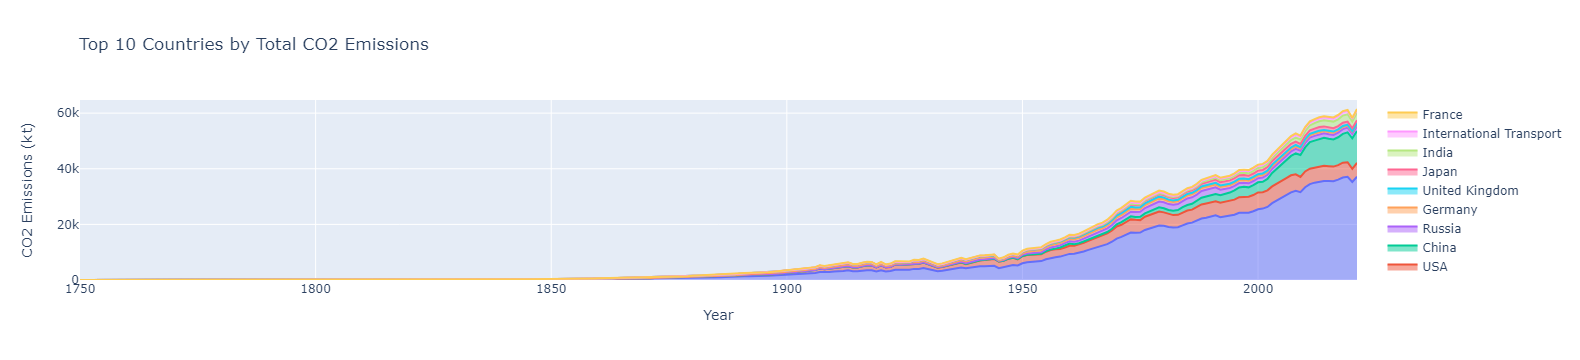

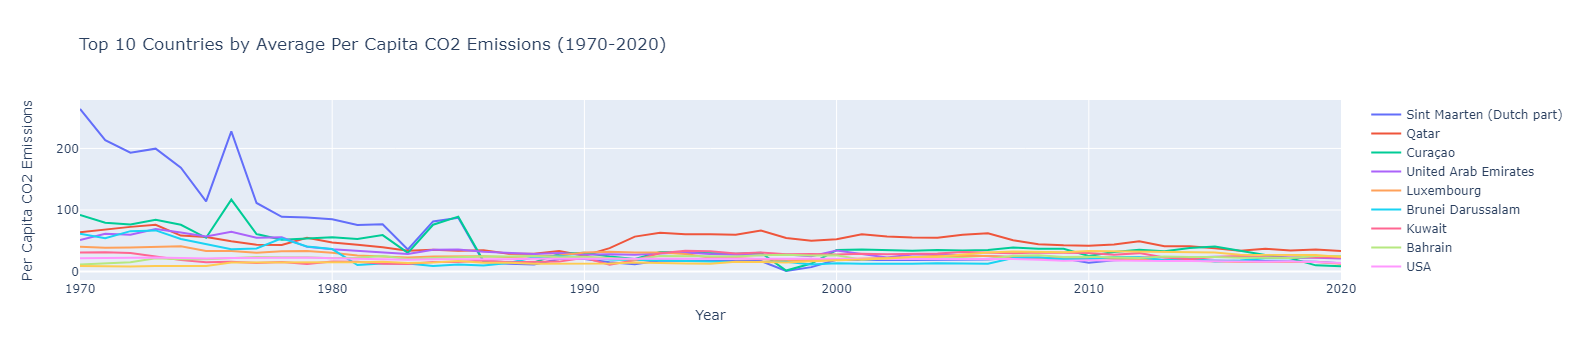

In [95]:
import pandas as pd

def load_co2_data(co2_csv_url='https://github.com/GIBDUSC/test/raw/master/CO2_emission.csv'):
    """
    Load CO2 emission data from a given URL.

    Args:
    co2_csv_url (str): CO2 emission CSV file URL.
    
    Returns:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    """
    co2_data = pd.read_csv(co2_csv_url, usecols=['Country', 'Year', 'Total', 'Per Capita'])
    return co2_data
import geopandas as gpd

def load_country_boundaries(country_geojson_url='https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json'):
    """
    Load country boundaries GeoJSON
    
    Parameters:
    country_geojson_url (str): Country boundaries GeoJSON URL (default: 'https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json')
    
    Returns:
    country_boundaries (GeoDataFrame): Loaded country boundaries GeoDataFrame
    """
    country_boundaries = gpd.read_file(country_geojson_url).set_crs("EPSG:3857")
    return country_boundaries
def calculate_average_per_capita(co2_data):
    """
    Calculate average per capita CO2 emission between 1970 and 2020.

    Args:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    
    Returns:
    average_per_capita_data (pd.DataFrame): Dataframe with average per capita CO2 emissions for each country.
    """

    # Filter data between 1970 and 2020
    filtered_data = co2_data[(co2_data['Year'] >= 1970) & (co2_data['Year'] <= 2020)]

    # Group data by country and compute the average per capita CO2 emissions
    average_per_capita_data = filtered_data.groupby('Country')['Per Capita'].mean().reset_index()

    return average_per_capita_data
import folium
from folium.plugins import FloatImage

def create_interactive_map(country_boundaries, average_per_capita_data):
    """
    Create interactive map with average per capita CO2 emissions.

    Args:
    country_boundaries (GeoDataFrame): Loaded country boundaries GeoDataFrame.
    average_per_capita_data (pd.DataFrame): Dataframe with average per capita CO2 emissions for each country.

    Returns:
    interactive_map (folium.Map): Interactive map visualization.
    """

    # Combine country boundaries and average per capita CO2 emissions
    merged_data = country_boundaries.merge(average_per_capita_data, how='inner', left_on='name', right_on='Country')

    # Create an interactive map with the merged data
    interactive_map = folium.Map(location=[50, 0], zoom_start=3, tiles="cartodb positron")

    choropleth = folium.Choropleth(
        geo_data=merged_data,
        name='Average Per Capita CO2 Emissions',
        data=merged_data,
        columns=['Country', 'Per Capita'],
        key_on='properties.name',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Average Per Capita CO2 Emissions',
    ).add_to(interactive_map)

    # Add country name labels on hover
    folium.GeoJson(
        merged_data,
        style_function=lambda x: {"opacity":0},
        tooltip=folium.features.GeoJsonTooltip(fields=['Country', 'Per Capita'], labels=True, sticky=False)
    ).add_to(choropleth.geojson)

    return interactive_map
def calculate_top10_total_emissions(co2_data):
    """
    Calculate top 10 countries by total CO2 emissions.

    Args:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    
    Returns:
    top10_total_emissions (pd.DataFrame): Dataframe containing the top 10 countries by total CO2 emissions.
    """
    total_emissions = co2_data.groupby('Country')['Total'].sum().reset_index()
    top10_total_emissions = total_emissions.nlargest(10, 'Total')
    return top10_total_emissions
import pandas as pd
import plotly.graph_objs as go

def create_stacked_area_chart(co2_data):
    """
    Create stacked area chart for top 10 countries by total CO2 emissions

    Args:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    
    Returns:
    stacked_area_chart (plotly.graph_objs.Figure): Stacked area chart for top 10 countries by total CO2 emissions.
    """

    top10_total_emissions = co2_data.groupby('Country').agg({'Total': 'sum'}).nlargest(10, 'Total')
    top10_countries = top10_total_emissions.index.tolist()
    top10_co2_data = co2_data[co2_data['Country'].isin(top10_countries)]

    traces = []
    for country in top10_countries:
        country_data = top10_co2_data[top10_co2_data['Country'] == country]
        trace = go.Scatter(
            x=country_data['Year'],
            y=country_data['Total'],
            mode='lines',
            stackgroup='one',
            name=country
        )
        traces.append(trace)

    layout = go.Layout(
        title='Top 10 Countries by Total CO2 Emissions',
        xaxis=dict(title='Year'),
        yaxis=dict(title='CO2 Emissions (kt)'),
    )

    stacked_area_chart = go.Figure(data=traces, layout=layout)
    return stacked_area_chart
def calculate_top10_average_per_capita(average_per_capita_data):
    """
    Calculate top 10 countries by average per capita CO2 emissions.

    Args:
    average_per_capita_data (pd.DataFrame): Dataframe with average per capita CO2 emissions for each country.

    Returns:
    top10_average_per_capita (pd.DataFrame): Dataframe containing top 10 countries by average per capita CO2 emissions.
    """

    top10_average_per_capita = average_per_capita_data.nlargest(10, 'Per Capita').reset_index(drop=True)

    return top10_average_per_capita
import pandas as pd
import plotly.graph_objects as go

def create_line_chart(co2_data, top10_average_per_capita):
    """
    Create line chart for top 10 countries by average per capita CO2 emissions.

    Args:
    co2_data (pd.DataFrame): Dataframe containing the CO2 emission data.
    top10_average_per_capita (pd.DataFrame): Dataframe containing top 10 countries by average per capita CO2 emissions.
    
    Returns:
    line_chart (go.Figure): Line chart displaying top 10 countries by average per capita CO2 emissions between 1970 and 2020.
    """

    # Filter data between 1970 and 2020
    filtered_data = co2_data[(co2_data['Year'] >= 1970) & (co2_data['Year'] <= 2020)]

    # Filter the data for the top 10 countries
    top10_data = filtered_data[filtered_data['Country'].isin(top10_average_per_capita['Country'])]

    # Create the line chart
    line_chart = go.Figure()

    for country in top10_average_per_capita['Country']:
        country_data = top10_data[top10_data['Country'] == country]
        line_chart.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Per Capita'], 
                                        mode='lines', name=country))

    # Update chart layout
    line_chart.update_layout(title='Top 10 Countries by Average Per Capita CO2 Emissions (1970-2020)',
                             xaxis_title='Year',
                             yaxis_title='Per Capita CO2 Emissions')

    return line_chart
def create_final_layout(interactive_map, stacked_area_chart, line_chart):
    """
    Create final layout with the map and two charts.

    Args:
    interactive_map (folium.Map): Interactive map visualization.
    stacked_area_chart (plotly.graph_objs.Figure): Stacked area chart for top 10 countries by total CO2 emissions.
    line_chart (go.Figure): Line chart displaying top 10 countries by average per capita CO2 emissions between 1970 and 2020.
    
    Returns:
    final_layout (dict): A dictionary containing the map and charts.
    """
    final_layout = {
        "map": interactive_map,
        "stacked_area_chart": stacked_area_chart,
        "line_chart": line_chart
    }

    return final_layout
def main():
    # Load data
    co2_data = load_co2_data()
    country_boundaries = load_country_boundaries()

    # Calculate average per capita CO2 emissions
    average_per_capita_data = calculate_average_per_capita(co2_data)

    # Create interactive map
    interactive_map = create_interactive_map(country_boundaries, average_per_capita_data)

    # Calculate top 10 total emissions and average per capita
    top10_total_emissions = calculate_top10_total_emissions(co2_data)
    top10_average_per_capita = calculate_top10_average_per_capita(average_per_capita_data)

    # Create stacked area chart and line chart
    stacked_area_chart = create_stacked_area_chart(co2_data)
    line_chart = create_line_chart(co2_data, top10_average_per_capita)

    # Create final layout
    final_layout = create_final_layout(interactive_map, stacked_area_chart, line_chart)

    # Show results
    final_layout["map"].save('map.html')
    final_layout["stacked_area_chart"].show()
    final_layout["line_chart"].show()


if __name__ == "__main__":
    main()

In [96]:
interactive_map

In [113]:
def load_country_boundaries(country_geojson_url='https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json'):
    """
    Load country boundaries GeoJSON
    
    Parameters:
    country_geojson_url (str): Country boundaries GeoJSON URL (default: 'https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json')
    
    Returns:
    country_boundaries (GeoDataFrame): Loaded country boundaries GeoDataFrame
    """
    country_boundaries = gpd.read_file(country_geojson_url)#.set_crs("EPSG:3857")
    return country_boundaries

country_boundaries = load_country_boundaries()
country_boundaries

,id,name,Alpha-2,geometry
0,AFG,Afghanistan,AF,"POLYGON ((61.21469 35.64939, 62.23164 35.27276..."
1,AGO,Angola,AO,"MULTIPOLYGON (((23.91243 -10.92989, 24.01130 -..."
2,ALB,Albania,AL,"POLYGON ((21.03107 40.84852, 21.00282 40.57833..."
3,ARE,United Arab Emirates,AE,"POLYGON ((51.58192 24.24406, 51.75141 24.29318..."
4,ARG,Argentina,AR,"MULTIPOLYGON (((-66.96328 -54.89733, -67.55650..."
...,...,...,...,...
175,PSE,West Bank,PS,"POLYGON ((35.53672 32.39891, 35.53672 31.78484..."
176,YEM,Yemen,YE,"POLYGON ((53.10734 16.65415, 52.38701 16.38396..."
177,ZAF,South Africa,ZA,"POLYGON ((16.34181 -28.57418, 16.82203 -28.082..."
178,ZMB,Zambia,ZM,"POLYGON ((32.76836 -9.22687, 33.23446 -9.67719..."


In [114]:
country_boundaries.crs

In [104]:
country_boundaries = country_boundaries.rename(columns={'Alpha-2': 'Alpha_2'}) 

In [106]:
country_boundaries.to_file(r'E:\Research\LLM-Geo\interactive_visualization\world_countries.shp')